# Initialization

In [25]:
#@title Mounting Gdrive

USE_G_COLAB = True #@param {type:"boolean"}

if USE_G_COLAB:
    from google.colab import drive

    
    drive.mount('/content/drive', force_remount=True)   

Mounted at /content/drive


In [0]:
#@title Project Root

root_dir = ''

if USE_G_COLAB:
    root_dir = '/content/drive/My Drive/Colab Notebooks/playground/hafez/' #@param {type:"string"}

In [0]:
#@title Installing requried packages

!pip install -q tensorflow-gpu==2.0.0-beta1
!pip install -qU Unidecode
!pip install -qU watermark

In [0]:
#@title Custom Matplotlib Style
mpl_style = "https://gist.githubusercontent.com/m3hrdadfi/af8aca01094afb7d3e5b46de9ad8d509/raw/871ec5d721a3b438c3c896718ea4aafc91ea9744/gadfly.mplstyle" #@param {type:"string"}

!wget -q $mpl_style -O /root/.config/matplotlib/matplotlibrc

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import random
import sys
import io
import re
import time
import datetime
import os

from unidecode import unidecode
from pprint import pprint


%matplotlib inline
mpl.rc_file(mpl.matplotlib_fname())

In [0]:
%reload_ext watermark
%watermark -m -n -p tensorflow,numpy,matplotlib,sklearn -g

# Preparing the dataset

In [0]:
#@title Dataset/Outputs directory

dataset_dir = 'dataset' #@param {type:"string"}
dataset_dir = os.path.join(root_dir, dataset_dir)

output_dir = 'outputs'  #@param {type:"string"}
output_dir = os.path.join(root_dir, output_dir)

os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [0]:
texts = ''
identifier = 'غزل   ' #@param {type:"string"}
poem_file = 'hafez.txt' #@param {type:"string"}

with open(os.path.join(dataset_dir, poem_file), encoding='utf-8-sig') as f:
    for line in f.readlines():
        line = line.strip()
        
        if not identifier in line and line:
            texts += line
            
print(texts[:100])

# Preprocessing

In [0]:
def text2idx(text, char2idx):
    return np.array([char2idx[c] for c in text])


def build_vocab(text, verbose=True):
    vocab = sorted(set(text))
    
    char2idx = {u:i for i, u in enumerate(vocab)}
    idx2char = np.array(vocab)
    
    if verbose:
        print('{} unique characters\n'.format(len(vocab)))
        
    return vocab, char2idx, idx2char

In [0]:
vocab, char2idx, idx2char = build_vocab(texts)
sequences = text2idx(texts, char2idx)

print ('{}\n mapped to integers:\n {}'.format(repr(texts[:10]), sequences[:10]))

In [0]:
#@title Train-Validating Split

valid_rate = 0.2 #@param {type:"number"}
valid_splitter = int(len(sequences) - len(sequences) * valid_rate)

train_seq = sequences[:valid_splitter]
valid_seq = sequences[valid_splitter:]


NUM_TRAIN = len(train_seq)
NUM_VALID = len(valid_seq)

print('Total: %s\nTrain: %s\nValidating: %s' %(sequences.shape, train_seq.shape, valid_seq.shape))

In [0]:
def split_xy(chunk):
    x = chunk[:-1]
    y = chunk[1:]
    return x, y

In [37]:
#@title Preparing the dataset

SEQ_LENGTH = 50 #@param {type:"integer"}
BATCH_SIZE = 32 #@param {type:"integer"}
BUFFER_SIZE = 10000 #@param {type:"integer"}

train_char_dataset = tf.data.Dataset.from_tensor_slices(train_seq)
valid_char_dataset = tf.data.Dataset.from_tensor_slices(valid_seq)

print('Train char:')
for i in train_char_dataset.take(5):
    print(idx2char[i.numpy()])

print('Valid char:')
for i in valid_char_dataset.take(5):
    print(idx2char[i.numpy()])


train_sequences = train_char_dataset.batch(SEQ_LENGTH + 1, drop_remainder=True)
valid_sequences = valid_char_dataset.batch(SEQ_LENGTH + 1, drop_remainder=True)

print()
print('Train sequences:')
for item in train_sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

print('Valid sequences:')
for item in valid_sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

train_dataset = train_sequences.map(split_xy)
valid_dataset = valid_sequences.map(split_xy)

print()
print('Train dataset: %s\nValidating dataset: %s' %(train_dataset, valid_dataset))

Train char:
ا
ل
ا
 
ي
Valid char:
ا
ر
 
ن
ص

Train sequences:
'الا يا ايها الساقی ادر کاسا و ناولهاکه عشق آسان نمو'
'د اول ولی افتاد مشکل\u200cهابه بوی نافه\u200cای کاخر صبا زان '
'طره بگشايدز تاب جعد مشکينش چه خون افتاد در دل\u200cهامرا'
' در منزل جانان چه امن عيش چون هر دمجرس فرياد می\u200cدار'
'د که بربنديد محمل\u200cهابه می سجاده رنگين کن گرت پير مغ'
Valid sequences:
'ار نصيحت نيوش کنساقی که جامت از می صافی تهی مبادچشم'
' عنايتی به من دردنوش کنسرمست در قبای زرافشان چو بگذ'
'ریيک بوسه نذر حافظ پشمينه پوش کنکرشمه\u200cای کن و بازار'
' ساحری بشکنبه غمزه رونق و ناموس سامری بشکنبه باد ده'
' سر و دستار عالمی يعنیکلاه گوشه به آيين سروری بشکنب'

Train dataset: <MapDataset shapes: ((50,), (50,)), types: (tf.int64, tf.int64)>
Validating dataset: <MapDataset shapes: ((50,), (50,)), types: (tf.int64, tf.int64)>


In [38]:
for x_et, y_et in train_dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[x_et.numpy()])))
    print('Target data:', repr(''.join(idx2char[y_et.numpy()])))
    
    
for i, (x_t, y_t) in enumerate(zip(x_et[:5], y_et[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(x_t, repr(idx2char[x_t])))
    print("  expected output: {} ({:s})".format(y_t, repr(idx2char[y_t])))
    
    
for x_ev, y_ev in valid_dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[x_ev.numpy()])))
    print('Target data:', repr(''.join(idx2char[y_ev.numpy()])))
    
    
for i, (x_v, y_v) in enumerate(zip(x_ev[:5], y_ev[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(x_v, repr(idx2char[x_v])))
    print("  expected output: {} ({:s})".format(y_v, repr(idx2char[y_v])))

Input data:  'الا يا ايها الساقی ادر کاسا و ناولهاکه عشق آسان نم'
Target data: 'لا يا ايها الساقی ادر کاسا و ناولهاکه عشق آسان نمو'
Step    0
  input: 2 ('ا')
  expected output: 23 ('ل')
Step    1
  input: 23 ('ل')
  expected output: 2 ('ا')
Step    2
  input: 2 ('ا')
  expected output: 0 (' ')
Step    3
  input: 0 (' ')
  expected output: 28 ('ي')
Step    4
  input: 28 ('ي')
  expected output: 2 ('ا')
Input data:  'ار نصيحت نيوش کنساقی که جامت از می صافی تهی مبادچش'
Target data: 'ر نصيحت نيوش کنساقی که جامت از می صافی تهی مبادچشم'
Step    0
  input: 2 ('ا')
  expected output: 11 ('ر')
Step    1
  input: 11 ('ر')
  expected output: 0 (' ')
Step    2
  input: 0 (' ')
  expected output: 25 ('ن')
Step    3
  input: 25 ('ن')
  expected output: 15 ('ص')
Step    4
  input: 15 ('ص')
  expected output: 28 ('ي')


# Arch

In [0]:
#@title Parameters Setup

# Length of the vocabulary in chars
VOCAB_SIZE = len(vocab)

# The embedding dimension
EMBEDDING_DIM = 100 #@param {type:"integer"}

# Number of RNN units
RNN_UNITS = 300 #@param {type:"integer"}

# Dropout rate
DROPOUT_RATE = 0.2 #@param {type:"number"}

# Epochs
EPOCHS = 10 #@param {type:"integer"}

# Learning rate
LR = 0.0005 #@param {type:"number"}

# Output every
EVERY_BATCH = 20 #@param {type:"integer"}
EVERY_EPOCH = 5 #@param {type:"integer"}

In [40]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
valid_dataset = valid_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

print('Train dataset: %s\nValidating dataset: %s' %(train_dataset, valid_dataset))

Train dataset: <BatchDataset shapes: ((32, 50), (32, 50)), types: (tf.int64, tf.int64)>
Validating dataset: <BatchDataset shapes: ((32, 50), (32, 50)), types: (tf.int64, tf.int64)>


In [0]:
def generate_text(seed_text, next_words, model):
    # Converting our start string to numbers (vectorizing)
    x_eval = [char2idx[s] for s in seed_text]
    x_eval = tf.expand_dims(x_eval, 0)
    
    # Empty string to store our results
    text_generated = []
    
    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0
    
    # Here batch size == 1
    model.reset_states()
    for i in range(next_words):
        predictions = model(x_eval)
        
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        x_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
        
    
    return seed_text + ''.join(text_generated)

def scc_loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)


def build_model(vocab_size, embedding_dim, rnn_units, batch_size, dropout_rate):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(vocab_size)
    ])
    
    return model

In [42]:
model = build_model(vocab_size=VOCAB_SIZE, 
                    embedding_dim=EMBEDDING_DIM, 
                    rnn_units=RNN_UNITS, 
                    batch_size=BATCH_SIZE, 
                    dropout_rate=DROPOUT_RATE)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (32, None, 100)           3600      
_________________________________________________________________
dropout_12 (Dropout)         (32, None, 100)           0         
_________________________________________________________________
lstm_8 (LSTM)                (32, None, 300)           481200    
_________________________________________________________________
dropout_13 (Dropout)         (32, None, 300)           0         
_________________________________________________________________
lstm_9 (LSTM)                (32, None, 300)           721200    
_________________________________________________________________
dropout_14 (Dropout)         (32, None, 300)           0         
_________________________________________________________________
dense_4 (Dense)              (32, None, 36)           

# Generating Text before Training

In [43]:
#@title Text Generating [before training]
# Sample seed text
SEED_TEXT = 'تو ترحم نکنی بر من مخلص گفتم' #@param {type:"string"}
# Next words
NEXT_WORDS = 10 #@param {type:"integer"}


model_before_training = build_model(
    vocab_size=VOCAB_SIZE, 
    embedding_dim=EMBEDDING_DIM, 
    rnn_units=RNN_UNITS, 
    batch_size=1, 
    dropout_rate=DROPOUT_RATE)

model_before_training.build(tf.TensorShape([1, None]))

og = generate_text(SEED_TEXT, NEXT_WORDS, model_before_training)
print(og)

تو ترحم نکنی بر من مخلص گفتمفمهشثذاسنن


In [44]:
#@title Callbacks Setup

checkpoints = 'checkpoints' #@param {type: "string"}
checkpoints = os.path.join(output_dir, checkpoints)
checkpoint_dir = checkpoints + datetime.datetime.now().strftime("_%Y_%m_%d_%H_%M_%S")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

os.makedirs(os.path.dirname(checkpoint_prefix), exist_ok=True)
checkpoint_prefix

'/content/drive/My Drive/Colab Notebooks/playground/hafez/outputs/checkpoints_2019_07_06_12_39_16/ckpt_{epoch}'

In [45]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

model = build_model(
    vocab_size=VOCAB_SIZE, 
    embedding_dim=EMBEDDING_DIM, 
    rnn_units=RNN_UNITS, 
    batch_size=BATCH_SIZE, 
    dropout_rate=DROPOUT_RATE)


@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = tf.reduce_mean(scc_loss(y, predictions))
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss



r_loss = []
r_val_loss = []

for epoch in range(EPOCHS):
    start = time.time()
    
    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = model.reset_states()
    
    print('=' * 100)
    print('Epoch: %04d' % (epoch + 1))
    
    train_loss = 0
    num_train = 1
    for (batch_n, (x, y)) in enumerate(train_dataset):
        train_loss += train_step(x, y)        
        num_train += 1
    
    train_loss /= num_train
    r_loss.append(train_loss.numpy())
    print('-' * 100)
    print('Training Loss: %2.4f' % train_loss)
    
    # Run a validation loop at the end of each epoch.
    val_loss = 0
    num_val = 1
    for x_val, y_val in valid_dataset:
        y_val_pred = model(x_val)
        val_loss += tf.reduce_mean(scc_loss(y_val, y_val_pred))
        num_val += 1
    
    val_loss /= num_val
    r_val_loss.append(val_loss.numpy())
    print('-' * 100)
    print('Validation Loss: %2.4f' % val_loss)
    
    print('-' * 100)
    print('Time taken for 1 epoch %s sec' % (time.time() - start))
    print('=' * 100)
    print()
    
    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % EVERY_EPOCH == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))
    
model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch: 0001
----------------------------------------------------------------------------------------------------
Training Loss: 2.9915
----------------------------------------------------------------------------------------------------
Validation Loss: 2.8949
----------------------------------------------------------------------------------------------------
Time taken for 1 epoch 6.853866100311279 sec

Epoch: 0002
----------------------------------------------------------------------------------------------------
Training Loss: 2.7760
----------------------------------------------------------------------------------------------------
Validation Loss: 2.6565
----------------------------------------------------------------------------------------------------
Time taken for 1 epoch 2.2430481910705566 sec

Epoch: 0003
----------------------------------------------------------------------------------------------------
Training Loss: 2.6123
--------------------------------------------------

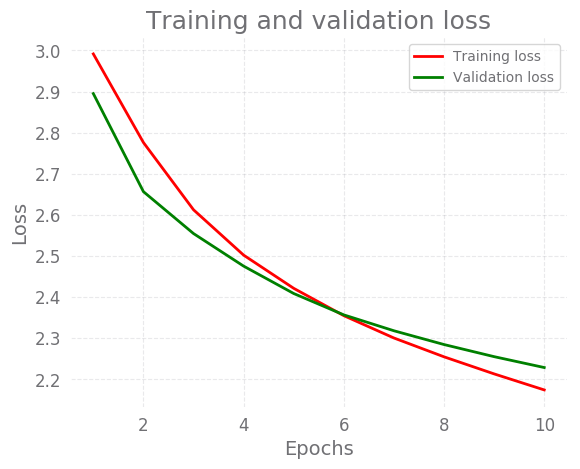

In [46]:
epochs = range(1, len(r_loss) + 1)

# plt.figure(figsize=(11.7, 8.27))
plt.plot(epochs, r_loss, 'r', label='Training loss')
plt.plot(epochs, r_val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [47]:
tf.train.latest_checkpoint(checkpoint_dir)

'/content/drive/My Drive/Colab Notebooks/playground/hafez/outputs/checkpoints_2019_07_06_12_39_16/ckpt_9'

# Generating Text after Training

In [48]:
#@title Text Generating [after training]
# Sample seed text
SEED_TEXT = 'تو ترحم نکنی بر من مخلص گفتم' #@param {type:"string"}
# Next words
NEXT_WORDS = 50 #@param {type:"integer"}

model_after_training = build_model(
    vocab_size=VOCAB_SIZE, 
    embedding_dim=EMBEDDING_DIM, 
    rnn_units=RNN_UNITS, 
    batch_size=1, 
    dropout_rate=DROPOUT_RATE)
model_after_training.load_weights(tf.train.latest_checkpoint(checkpoint_dir)) 
model_after_training.build(tf.TensorShape([1, None]))

og = generate_text(SEED_TEXT, NEXT_WORDS, model_after_training)
print(og)

تو ترحم نکنی بر من مخلص گفتم طره‌اک و شبرخواهد مگل جسوتانم عدم پيشا کاروستگست 
